In [1]:
import numpy as np 
import scipy as sp  
import random     
import bokeh 
import csv
import pandas as pd 
import struct
import os, pickle,sys
import matplotlib.pyplot as plt 
#import dill as pickle
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
pd.set_option('display.max_columns', None)

from datetime import datetime
import pandas as pd
import datetime
# from dataprep.eda import * 
import pytz
import math
from scipy import misc

import warnings
warnings.filterwarnings('ignore')

In [71]:
df_rdb_entrance = pd.read_csv('rdb3_entrance.csv') #pd.concat(df_list)

In [72]:
df_rdb_entrance

,identifier,location,direction,X,Y
0,19,East,Exit,618156.20926,5.806280e+06
1,6,South,Enter,618146.18921,5.806264e+06
2,46,North,Exit,618129.37373,5.806296e+06
3,34,East,Enter,618153.85195,5.806289e+06
4,73,West,Exit,618120.60738,5.806277e+06
5,80,West,Enter,618122.57686,5.806271e+06
6,91,South,Exit,618138.07216,5.806262e+06
7,61,North,Enter,618123.56380,5.806291e+06


In [3]:
import glob
csv_list=glob.glob("*.csv")
csv_list.remove('rdb3_entrance.csv')

In [69]:
csv_list = ['rdb3_219.csv',
 'rdb3_248.csv',
 'rdb3_212.csv',
 'rdb3_260.csv',
 'rdb3_222.csv',
 'rdb3_246.csv',
 'rdb3_249.csv',
 'rdb3_218.csv',
 'rdb3_224.csv',
 'rdb3_228.csv',
 'rdb3_244.csv',
 'rdb3_240.csv',
 'rdb3_238.csv',
 'rdb3_231.csv',
 'rdb3_232.csv',
 'rdb3_256.csv',
 'rdb3_250.csv',
 'rdb3_215.csv',
 'rdb3_214.csv',
 'rdb3_262.csv',
 'rdb3_263.csv',
 'rdb3_242.csv',
 'rdb3_253.csv',
 'rdb3_221.csv',
 'rdb3_227.csv',
 'rdb3_211.csv',
 'rdb3_225.csv',
 'rdb3_251.csv',
 'rdb3_210.csv',
 'rdb3_223.csv',
 'rdb3_255.csv',
 'rdb3_247.csv',
 'rdb3_243.csv',
 'rdb3_233.csv',
 'rdb3_229.csv',
 'rdb3_235.csv',
 'rdb3_213.csv',
 'rdb3_259.csv',
 'rdb3_236.csv',
 'rdb3_234.csv',
 'rdb3_217.csv',
 'rdb3_258.csv',
 'rdb3_237.csv',
 'rdb3_230.csv',
 'rdb3_216.csv',
 'rdb3_245.csv',
 'rdb3_220.csv',
 'rdb3_226.csv',
 'rdb3_261.csv',
 'rdb3_241.csv',
 'rdb3_239.csv',
 'rdb3_254.csv',
 'rdb3_252.csv',
 'rdb3_257.csv']

In [70]:
radius_rdb =  ((618138.29192028-618138.81823350)**2+ (5806298.28459249-5806261.86371654)**2)**0.5/2 #the outer diameter includes width of lane not just inner diameter
#the width of lane is 6.5m
center_X_rdb=618138.564068704
center_Y_rdb=5806279.451916209


In [74]:
 #get complete record for further analysis

def data_process( df_rdb ):
    
    
    df_rdb['DISTANCE_CENTER']= ((df_rdb['UTM_X']-center_X_rdb)**2+(df_rdb['UTM_Y']-center_Y_rdb)**2)**0.5 # get distance to rdb center 

    df_rdb['IS_IN']= df_rdb['DISTANCE_CENTER']<radius_rdb #obj in rdb
    
    df_rdb['ENTER']=None
    df_rdb['EXIT']=None
    df_rdb['ENTERING']= (df_rdb['DISTANCE_CENTER']<radius_rdb+6)&(df_rdb['DISTANCE_CENTER']>radius_rdb-1) 
    df_rdb['QUEUEING']= (df_rdb['DISTANCE_CENTER']<radius_rdb+20)&(df_rdb['DISTANCE_CENTER']>radius_rdb-2)


    df_rdb_group=df_rdb.groupby('OBJID')

    for j in range(len(list(df_rdb_group.groups.keys()))):
        x = list(df_rdb_group.groups.keys())[j]  #key
        y = df_rdb.loc[df_rdb_group.groups[list(df_rdb_group.groups.keys())[j]],:]  #extracted dataframe

        distance_start_center=(((center_X_rdb-y.loc[y.index[0],].UTM_X)**2+ (center_Y_rdb-y.loc[y.index[0],].UTM_Y)**2)**0.5) #for each obj,distance between start point to center
        distance_end_center=(((center_X_rdb-y.loc[y.index[y.shape[0]-1],].UTM_X)**2+ (center_Y_rdb-y.loc[y.index[y.shape[0]-1],].UTM_Y)**2)**0.5) #for each obj,distance between last point to center

        if (distance_start_center>radius_rdb) & (distance_end_center>radius_rdb) & (sum(y.IS_IN)>0): #complete record for one obj that can be used for further analysis
            enter_index=(((df_rdb_entrance[df_rdb_entrance['direction']=='Enter'].X-y.loc[y.index[0],].UTM_X)**2+ \
                          (df_rdb_entrance[df_rdb_entrance['direction']=='Enter'].Y-y.loc[y.index[0],].UTM_Y)**2)**0.5).idxmin()
            enter_direction = df_rdb_entrance.loc[enter_index,'location']
            exist_index=(((df_rdb_entrance[df_rdb_entrance['direction']=='Exit'].X-y.loc[y.index[y.shape[0]-1],].UTM_X)**2+ \
                          (df_rdb_entrance[df_rdb_entrance['direction']=='Exit'].Y-y.loc[y.index[y.shape[0]-1],].UTM_Y)**2)**0.5).idxmin()
            exist_direction =df_rdb_entrance.loc[exist_index,'location']

            df_rdb.loc[df_rdb_group.groups[list(df_rdb_group.groups.keys())[j]],'ENTER']=enter_direction
            df_rdb.loc[df_rdb_group.groups[list(df_rdb_group.groups.keys())[j]],'EXIT']=exist_direction


    df_rdb = df_rdb.drop(['TRAILER_ID'], axis=1)
    df_rdb = df_rdb.dropna()
    df_rdb.drop(df_rdb[df_rdb.CLASS=='Trailer'].index,inplace=True)
    df_rdb.drop(df_rdb[df_rdb.CLASS=='Motorcycle'].index,inplace=True)
    df_rdb.drop(df_rdb[df_rdb.CLASS=='Bicycle'].index,inplace=True)
    df_rdb.drop(df_rdb[df_rdb.CLASS=='Pedestrian'].index,inplace=True)
    # df_rdb.drop(df_rdb[df_rdb.CLASS=='Heavy Vehicle'].index,inplace=True)
    # df_rdb.drop(df_rdb[df_rdb.CLASS=='Medium Vehicle'].index,inplace=True)
    # df_rdb.drop(df_rdb[df_rdb.CLASS=='Bus'].index,inplace=True)

    

    
    
    
    
    return df_rdb

In [75]:
# get the entering moment (corresponding record) of each obj (only one record for each entering obj)
def enter_moment(df_rdb):
    df_rdb_group=df_rdb.groupby('OBJID')
    df_enter_moment=pd.DataFrame([])

    for j in range(len(list(df_rdb_group.groups.keys()))):
        x = list(df_rdb_group.groups.keys())[j]  #key
        y = df_rdb.loc[df_rdb_group.groups[list(df_rdb_group.groups.keys())[j]],:]  #extracted dataframe

        enter_moment_index = np.where(y['IS_IN'].values==True)[0][0] #the index of the first row when obj's IS_IN become true 
        df_enter_moment = df_enter_moment.append(pd.DataFrame(df_rdb.loc[y.iloc[enter_moment_index,].name]).transpose())
    return df_enter_moment

In [76]:
conflict_dictionary = {'North': ['East-West', 'East-South', 'East-East', 'South-West','South-South','West-West'],\
                       'West': ['North-South', 'North-East', 'North-North', 'East-South','East-East','South-South'],\
                       'South': ['West-East', 'West-North', 'West-West', 'North-East','North-North','East-East'],\
                       'East': ['South-North', 'South-West', 'South-South', 'West-North','West-West','North-North']}

def is_conflict(direction,corresponding_record):
    veh_entrance_exit=pd.DataFrame(corresponding_record.groupby(['OBJID','ENTER','EXIT']).size()).reset_index()
    veh_entrance_exit_set = set(list(veh_entrance_exit.ENTER+'-'+veh_entrance_exit.EXIT))
    
    if direction in ['North','West','South','East']:
        if len(veh_entrance_exit_set.intersection(set(conflict_dictionary[direction])))>0:
            result = 1
        else: 
            result = 0
    
    return result

In [77]:
alpha=14.8*0.3048   
t_rps=1.33
x = 0.5

def f(x):
    return beta1*(math.exp(-x*(2*t_rps+vc/alpha))+math.exp(-x*(3*t_rps+(6/5)*vc/alpha))+math.exp(-x*(4*t_rps+(8/5)*vc/alpha))+\
                 math.exp(-x*(5*t_rps+(11/5)*vc/alpha))+math.exp(-x*(6*t_rps+(15/5)*vc/alpha))+\
                 math.exp(-x*(7*t_rps+(20/5)*vc/alpha))/(1-math.exp(-x*(t_rps+vc/alpha))))-1 


def NewtonsMethod(f, x = 0.5, tolerance=0.000001):
    while True:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
    return x


In [78]:
# get q_e by model(one equation),not the over_saturated condistion with beta 

def circulating_flow(x_q_c,t_rps,vc,alpha):
    return x_q_c * (math.exp(-x_q_c*(2*t_rps+vc/alpha))+math.exp(-x_q_c*(3*t_rps+(6/5)*vc/alpha))+math.exp(-x_q_c*(4*t_rps+(8/5)*vc/alpha))+\
                    math.exp(-x_q_c*(5*t_rps+(11/5)*vc/alpha))+math.exp(-x_q_c*(6*t_rps+(15/5)*vc/alpha))+\
                    math.exp(-x_q_c*(7*t_rps+(20/5)*vc/alpha))/(1-math.exp(-x_q_c*(t_rps+vc/alpha))))
    

In [79]:
# get status of four legs if obj enters
threshold_queue_speed = 1 # derive queue by speed threshold. the first condition of queue, speed<1m/s

def entering_status(df_rdb):
    df_entering_status=pd.DataFrame([])
    df_entering_status['TIMESTAMP_START'] = None
    df_entering_status['TIMESTAMP_END'] = None
    df_entering_status['NUMBER_BUSY_ENTRANCE'] = None
    df_entering_status['NUMBER_QUEUE_ENTRANCE'] = None
    df_entering_status['NORTH_ENTER_NUMBER'] = None
    df_entering_status['NORTH_ENTER_OBJID'] = None
    df_entering_status['NORTH_QUEUE_NUMBER'] = None
    df_entering_status['NORTH_QUEUE_OBJID'] = None
    df_entering_status['NORTH_QUEUE_IS'] = None
    df_entering_status['SOUTH_ENTER_NUMBER'] = None
    df_entering_status['SOUTH_ENTER_OBJID'] = None
    df_entering_status['SOUTH_QUEUE_NUMBER'] = None
    df_entering_status['SOUTH_QUEUE_OBJID'] = None
    df_entering_status['SOUTH_QUEUE_IS'] = None
    df_entering_status['WEST_ENTER_NUMBER'] = None
    df_entering_status['WEST_ENTER_OBJID'] = None
    df_entering_status['WEST_QUEUE_NUMBER'] = None
    df_entering_status['WEST_QUEUE_OBJID'] = None
    df_entering_status['WEST_QUEUE_IS'] = None
    df_entering_status['EAST_ENTER_NUMBER'] = None
    df_entering_status['EAST_ENTER_OBJID'] = None
    df_entering_status['EAST_QUEUE_NUMBER'] = None
    df_entering_status['EAST_QUEUE_OBJID'] = None
    df_entering_status['EAST_QUEUE_IS'] = None

    df_rdb_group = df_rdb.groupby(pd.cut(df_rdb["TIMESTAMP"], np.arange(0, max(df_rdb["TIMESTAMP"]), 1), right = False))  #per one second
    for j in range(len(list(df_rdb_group.groups.keys()))):
    # j=1
        x = list(df_rdb_group.groups.keys())[j]  #key
        y = df_rdb.loc[df_rdb_group.groups[list(df_rdb_group.groups.keys())[j]],:]  #extracted dataframe
        y_enter = y[y['ENTERING']==True] # obj records within the limitation of entering
        y_queue = y[y['QUEUEING']==True] # obj records within the limitation of possible queue
        df_entering_status = df_entering_status.append(dict({'TIMESTAMP_START':x.left,\
                'TIMESTAMP_END':x.right,\
                'NUMBER_BUSY_ENTRANCE':len(y_enter['ENTER'].unique()),\
                'NUMBER_QUEUE_ENTRANCE':len(y_queue[y_queue['V']<threshold_queue_speed]['ENTER'].unique()),\
                'NORTH_ENTER_NUMBER':len(y_enter[y_enter['ENTER'] == 'North']['OBJID'].unique()),\
                'NORTH_ENTER_OBJID':list(y_enter[y_enter['ENTER'] == 'North']['OBJID'].unique()),\
                'NORTH_QUEUE_NUMBER':len(y_queue[(y_queue['ENTER'] == 'North') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'NORTH_QUEUE_OBJID':list(y_queue[(y_queue['ENTER'] == 'North') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'NORTH_QUEUE_IS': int(len(y_queue[(y_queue['ENTER'] == 'North') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique())>0),\
                'SOUTH_ENTER_NUMBER':len(y_enter[y_enter['ENTER'] == 'South']['OBJID'].unique()),\
                'SOUTH_ENTER_OBJID':list(y_enter[y_enter['ENTER'] == 'South']['OBJID'].unique()),\
                'SOUTH_QUEUE_NUMBER':len(y_queue[(y_queue['ENTER'] == 'South') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'SOUTH_QUEUE_OBJID':list(y_queue[(y_queue['ENTER'] == 'South') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'SOUTH_QUEUE_IS': int(len(y_queue[(y_queue['ENTER'] == 'South') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique())>0),\
                'WEST_ENTER_NUMBER':len(y_enter[y_enter['ENTER'] == 'West']['OBJID'].unique()),\
                'WEST_ENTER_OBJID':list(y_enter[y_enter['ENTER'] == 'West']['OBJID'].unique()),\
                'WEST_QUEUE_NUMBER':len(y_queue[(y_queue['ENTER'] == 'West') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'WEST_QUEUE_OBJID':list(y_queue[(y_queue['ENTER'] == 'West') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'WEST_QUEUE_IS': int(len(y_queue[(y_queue['ENTER'] == 'West') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique())>0),\
                'EAST_ENTER_NUMBER':len(y_enter[y_enter['ENTER'] == 'East']['OBJID'].unique()),\
                'EAST_ENTER_OBJID':list(y_enter[y_enter['ENTER'] == 'East']['OBJID'].unique()),\
                'EAST_QUEUE_NUMBER':len(y_queue[(y_queue['ENTER'] == 'East') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'EAST_QUEUE_OBJID':list(y_queue[(y_queue['ENTER'] == 'East') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique()),\
                'EAST_QUEUE_IS': int(len(y_queue[(y_queue['ENTER'] == 'East') & (y_queue['V']<threshold_queue_speed)]['OBJID'].unique())>0)}),ignore_index=True)

    return df_entering_status

In [80]:
time_duration=30
before_time = 25
after_time = 5
# enter status within time_duration
def entering_four_legs_trimmed(df_entering_status):
    df_entering_four_legs = df_entering_status
    # df_entering_four_legs = df_entering_status[df_entering_status['NUMBER_BUSY_ENTRANCE']==4]
    df_entering_four_legs_trimmed = df_entering_four_legs[(df_entering_four_legs.index>time_duration/2) & (df_entering_four_legs.index< math.floor(max(df_rdb["TIMESTAMP"]))-time_duration/2)]

    df_entering_four_legs_trimmed['NORTH_MAX_DURATION'] = None
    df_entering_four_legs_trimmed['SOUTH_MAX_DURATION'] = None
    df_entering_four_legs_trimmed['WEST_MAX_DURATION'] = None
    df_entering_four_legs_trimmed['EAST_MAX_DURATION'] = None

    for i in df_entering_four_legs_trimmed.index:
        df_entering_four_legs_trimmed.loc[i,'NORTH_MAX_DURATION'] = sum(df_entering_four_legs_trimmed.loc[i-time_duration/2:i+time_duration/2,'NORTH_QUEUE_IS'])
        df_entering_four_legs_trimmed.loc[i,'SOUTH_MAX_DURATION'] = sum(df_entering_four_legs_trimmed.loc[i-time_duration/2:i+time_duration/2,'SOUTH_QUEUE_IS'])
        df_entering_four_legs_trimmed.loc[i,'WEST_MAX_DURATION'] = sum(df_entering_four_legs_trimmed.loc[i-time_duration/2:i+time_duration/2,'WEST_QUEUE_IS'])
        df_entering_four_legs_trimmed.loc[i,'EAST_MAX_DURATION'] = sum(df_entering_four_legs_trimmed.loc[i-time_duration/2:i+time_duration/2,'EAST_QUEUE_IS'])
    return df_entering_four_legs_trimmed

In [81]:
# get queue by entering obj number in 30 sec
threshold_queue = 3  # the second condistion of queue, number of entering obj >=3 in 30 sec 

def container_north(df_entering_four_legs_trimmed):
    df_entering_four_legs_north_queue = df_entering_four_legs_trimmed[df_entering_four_legs_trimmed['NORTH_MAX_DURATION']>=threshold_queue]

    container_north = []

    for i in df_entering_four_legs_north_queue.index:
        for j in df_entering_four_legs_north_queue.loc[i,'NORTH_QUEUE_OBJID']:
            container_north.append(j)
    list_container_north = list(set(container_north))
    return list_container_north


def container_south(df_entering_four_legs_trimmed):
    df_entering_four_legs_south_queue = df_entering_four_legs_trimmed[df_entering_four_legs_trimmed['SOUTH_MAX_DURATION']>=threshold_queue]

    container_south = []

    for i in df_entering_four_legs_south_queue.index:
        for j in df_entering_four_legs_south_queue.loc[i,'SOUTH_QUEUE_OBJID']:
            container_south.append(j)
    list_container_south = list(set(container_south))
    return list_container_south


def container_west(df_entering_four_legs_trimmed):
    df_entering_four_legs_west_queue = df_entering_four_legs_trimmed[df_entering_four_legs_trimmed['WEST_MAX_DURATION']>=threshold_queue]

    container_west = []

    for i in df_entering_four_legs_west_queue.index:
        for j in df_entering_four_legs_west_queue.loc[i,'WEST_QUEUE_OBJID']:
            container_west.append(j)
    list_container_west = list(set(container_west))
    return list_container_west

def container_east(df_entering_four_legs_trimmed):
    df_entering_four_legs_east_queue = df_entering_four_legs_trimmed[df_entering_four_legs_trimmed['EAST_MAX_DURATION']>=threshold_queue]

    container_east = []

    for i in df_entering_four_legs_east_queue.index:
        for j in df_entering_four_legs_east_queue.loc[i,'EAST_QUEUE_OBJID']:
            container_east.append(j)
    list_container_east = list(set(container_east))
    return list_container_east

In [82]:
def north_result(list_container_north):
    
    selected_entrance = pd.DataFrame([])
    selected_entrance['NAME'] = None
    selected_entrance['TIMESTAMP_START'] = None
    selected_entrance['TIMESTAMP_END'] = None
    selected_entrance['OBJID'] = None
    selected_entrance['entrance_location'] = None
    selected_entrance['number_entering_vehicle'] = None
    selected_entrance['id_entering_vehicle'] = None
    selected_entrance['number_inner_vehicle'] = None
    selected_entrance['id_inner_vehicle'] = None
    selected_entrance['number_conflicting_vehicle'] = None
    selected_entrance['id_conflicting_vehicle'] = None

    selected_entrance['conflicting_speed'] = None
    selected_entrance['beta'] = None

    selected_entrance['q_c_model_per_second'] = None
    selected_entrance['q_e_model_per_second'] = None
    selected_entrance['q_c_gtd_per_second'] = None
    selected_entrance['q_e_gtd_per_second'] = None
    selected_entrance['q_c_hcm_per_second'] = None
    selected_entrance['q_e_hcm_per_second'] = None
    selected_entrance['q_c_model_per_hour'] = None
    selected_entrance['q_c_gtd_per_hour'] = None
    selected_entrance['q_c_hcm_per_hour'] = None
    selected_entrance['q_e_model_per_hour'] = None
    selected_entrance['q_e_gtd_per_hour'] = None
    selected_entrance['q_e_hcm_per_hour'] = None

    for iterm in list_container_north:
        corresponding_record_enter_time_point = float(df_enter_moment[df_enter_moment.OBJID == iterm].TIMESTAMP)

        corresponding_record_inner = df_rdb_inner[(df_rdb_inner.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_rdb_inner.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        corresponding_record_enter = df_enter_moment[(df_enter_moment.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_enter_moment.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        # entrance_count =  pd.DataFrame(corresponding_record_enter.groupby(['OBJID','ENTER']).size()).reset_index()['ENTER'].value_counts()
        
        id_entering_vehicle = set(corresponding_record_enter[corresponding_record_enter['ENTER'] == 'North']['OBJID'])
        id_inner_vehicle = set(corresponding_record_inner['OBJID'])

        veh_entrance_exit=pd.DataFrame(corresponding_record_inner.groupby(['OBJID','ENTER','EXIT']).size()).reset_index()
        veh_entrance_exit_list = list(veh_entrance_exit.ENTER+'-'+veh_entrance_exit.EXIT)
        id_conflicting_vehicle = set(veh_entrance_exit.loc[[i for i,x in enumerate(veh_entrance_exit_list) if x in conflict_dictionary['North']]]['OBJID'])

        corresponding_record_conflict = df_rdb_inner[df_rdb_inner.OBJID.isin(id_conflicting_vehicle)]
        # vc = corresponding_record_conflict.V.mean()

        if len(corresponding_record_conflict) == 0:
            break 

        
        p1=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
                    len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
                    len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
                    len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='East')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p2=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='North')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())

        p3=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='West')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p4=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='South')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        # time_duration=20
        alpha=14.8*0.3048   
        t_rps=1.33
        beta1=p2+p3*2+p4*3
        x = 0.5
        q_c_model_per_second = len(id_conflicting_vehicle)/time_duration
        
        q_e_model_per_second = circulating_flow(q_c_model_per_second,t_rps,vc,alpha)
        # q_c_model=NewtonsMethod(f, x)


        selected_entrance = selected_entrance.append(dict({'NAME':name,\
                                                            'TIMESTAMP_START':corresponding_record_enter_time_point-before_time,\
                                                            'TIMESTAMP_END':corresponding_record_enter_time_point+after_time,\
                                                            'OBJID':iterm,\
                                                            'entrance_location':'North',\
                                                            'number_entering_vehicle':len(id_entering_vehicle),\
                                                            'id_entering_vehicle':id_entering_vehicle,\
                                                            'number_inner_vehicle':len(id_inner_vehicle),\
                                                            'id_inner_vehicle':id_inner_vehicle,\
                                                            'number_conflicting_vehicle':len(id_conflicting_vehicle),\
                                                            'id_conflicting_vehicle':id_conflicting_vehicle,\
                                                            'conflicting_speed':vc,\
                                                            'beta':beta1,\
                                                            'q_c_model_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_model_per_second': q_e_model_per_second,\
                                                            # 'q_e_model_per_second': q_c_model/beta1,\
                                                            'q_c_gtd_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_gtd_per_second': len(id_entering_vehicle)/time_duration,\
                                                            'q_c_hcm_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_hcm_per_second': 1130*np.exp(-0.001*(len(id_conflicting_vehicle)/time_duration*3600))/60/60}),ignore_index=True)



        selected_entrance['q_c_model_per_hour'] = selected_entrance['q_c_model_per_second']*3600
        selected_entrance['q_c_gtd_per_hour'] = selected_entrance['q_c_gtd_per_second']*3600
        selected_entrance['q_c_hcm_per_hour'] = selected_entrance['q_c_hcm_per_second']*3600
        selected_entrance['q_e_model_per_hour'] = selected_entrance['q_e_model_per_second']*3600
        selected_entrance['q_e_gtd_per_hour'] = selected_entrance['q_e_gtd_per_second']*3600
        selected_entrance['q_e_hcm_per_hour'] = selected_entrance['q_e_hcm_per_second']*3600   
    return selected_entrance

In [83]:
def south_result(list_container_south):
    
    selected_entrance = pd.DataFrame([])
    selected_entrance['NAME'] = None
    selected_entrance['TIMESTAMP_START'] = None
    selected_entrance['TIMESTAMP_END'] = None
    selected_entrance['OBJID'] = None
    selected_entrance['entrance_location'] = None
    selected_entrance['number_entering_vehicle'] = None
    selected_entrance['id_entering_vehicle'] = None
    selected_entrance['number_inner_vehicle'] = None
    selected_entrance['id_inner_vehicle'] = None
    selected_entrance['number_conflicting_vehicle'] = None
    selected_entrance['id_conflicting_vehicle'] = None

    selected_entrance['conflicting_speed'] = None
    selected_entrance['beta'] = None

    selected_entrance['q_c_model_per_second'] = None
    selected_entrance['q_e_model_per_second'] = None
    selected_entrance['q_c_gtd_per_second'] = None
    selected_entrance['q_e_gtd_per_second'] = None
    selected_entrance['q_c_hcm_per_second'] = None
    selected_entrance['q_e_hcm_per_second'] = None
    selected_entrance['q_c_model_per_hour'] = None
    selected_entrance['q_c_gtd_per_hour'] = None
    selected_entrance['q_c_hcm_per_hour'] = None
    selected_entrance['q_e_model_per_hour'] = None
    selected_entrance['q_e_gtd_per_hour'] = None
    selected_entrance['q_e_hcm_per_hour'] = None

    for iterm in list_container_south:
        corresponding_record_enter_time_point = float(df_enter_moment[df_enter_moment.OBJID == iterm].TIMESTAMP)

        corresponding_record_inner = df_rdb_inner[(df_rdb_inner.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_rdb_inner.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        corresponding_record_enter = df_enter_moment[(df_enter_moment.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_enter_moment.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        # entrance_count =  pd.DataFrame(corresponding_record_enter.groupby(['OBJID','ENTER']).size()).reset_index()['ENTER'].value_counts()
        
        id_entering_vehicle = set(corresponding_record_enter[corresponding_record_enter['ENTER'] == 'South']['OBJID'])
        id_inner_vehicle = set(corresponding_record_inner['OBJID'])

        veh_entrance_exit=pd.DataFrame(corresponding_record_inner.groupby(['OBJID','ENTER','EXIT']).size()).reset_index()
        veh_entrance_exit_list = list(veh_entrance_exit.ENTER+'-'+veh_entrance_exit.EXIT)
        id_conflicting_vehicle = set(veh_entrance_exit.loc[[i for i,x in enumerate(veh_entrance_exit_list) if x in conflict_dictionary['South']]]['OBJID'])

        corresponding_record_conflict = df_rdb_inner[df_rdb_inner.OBJID.isin(id_conflicting_vehicle)]
        # vc = corresponding_record_conflict.V.mean()
        if len(corresponding_record_conflict) == 0:
            break

        
        p1=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='East')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p2=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='North')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())

        p3=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='West')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p4=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='South')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        # time_duration=20
        alpha=14.8*0.3048   
        t_rps=1.33
        beta1=p2+p3*2+p4*3
        x = 0.5
        q_c_model_per_second = len(id_conflicting_vehicle)/time_duration
        q_e_model_per_second = circulating_flow(q_c_model_per_second,t_rps,vc,alpha)
        # q_c_model=NewtonsMethod(f, x)


        selected_entrance = selected_entrance.append(dict({'NAME':name,\
                                                            'TIMESTAMP_START':corresponding_record_enter_time_point-before_time,\
                                                            'TIMESTAMP_END':corresponding_record_enter_time_point+after_time,\
                                                            'OBJID':iterm,\
                                                            'entrance_location':'South',\
                                                            'number_entering_vehicle':len(id_entering_vehicle),\
                                                            'id_entering_vehicle':id_entering_vehicle,\
                                                            'number_inner_vehicle':len(id_inner_vehicle),\
                                                            'id_inner_vehicle':id_inner_vehicle,\
                                                            'number_conflicting_vehicle':len(id_conflicting_vehicle),\
                                                            'id_conflicting_vehicle':id_conflicting_vehicle,\
                                                            'conflicting_speed':vc,\
                                                            'beta':beta1,\
                                                            'q_c_model_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_model_per_second': q_e_model_per_second,\
                                                            # 'q_e_model_per_second': q_c_model/beta1,\
                                                            'q_c_gtd_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_gtd_per_second': len(id_entering_vehicle)/time_duration,\
                                                            'q_c_hcm_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_hcm_per_second': 1130*np.exp(-0.001*(len(id_conflicting_vehicle)/time_duration*3600))/60/60}),ignore_index=True)


        selected_entrance['q_c_model_per_hour'] = selected_entrance['q_c_model_per_second']*3600
        selected_entrance['q_c_gtd_per_hour'] = selected_entrance['q_c_gtd_per_second']*3600
        selected_entrance['q_c_hcm_per_hour'] = selected_entrance['q_c_hcm_per_second']*3600
        selected_entrance['q_e_model_per_hour'] = selected_entrance['q_e_model_per_second']*3600
        selected_entrance['q_e_gtd_per_hour'] = selected_entrance['q_e_gtd_per_second']*3600
        selected_entrance['q_e_hcm_per_hour'] = selected_entrance['q_e_hcm_per_second']*3600   
    return selected_entrance

In [84]:
def west_result(list_container_west):
    
    selected_entrance = pd.DataFrame([])
    selected_entrance['NAME'] = None
    selected_entrance['TIMESTAMP_START'] = None
    selected_entrance['TIMESTAMP_END'] = None
    selected_entrance['OBJID'] = None
    selected_entrance['entrance_location'] = None
    selected_entrance['number_entering_vehicle'] = None
    selected_entrance['id_entering_vehicle'] = None
    selected_entrance['number_inner_vehicle'] = None
    selected_entrance['id_inner_vehicle'] = None
    selected_entrance['number_conflicting_vehicle'] = None
    selected_entrance['id_conflicting_vehicle'] = None

    selected_entrance['conflicting_speed'] = None
    selected_entrance['beta'] = None

    selected_entrance['q_c_model_per_second'] = None
    selected_entrance['q_e_model_per_second'] = None
    selected_entrance['q_c_gtd_per_second'] = None
    selected_entrance['q_e_gtd_per_second'] = None
    selected_entrance['q_c_hcm_per_second'] = None
    selected_entrance['q_e_hcm_per_second'] = None
    selected_entrance['q_c_model_per_hour'] = None
    selected_entrance['q_c_gtd_per_hour'] = None
    selected_entrance['q_c_hcm_per_hour'] = None
    selected_entrance['q_e_model_per_hour'] = None
    selected_entrance['q_e_gtd_per_hour'] = None
    selected_entrance['q_e_hcm_per_hour'] = None

    for iterm in list_container_west:
        corresponding_record_enter_time_point = float(df_enter_moment[df_enter_moment.OBJID == iterm].TIMESTAMP)

        corresponding_record_inner = df_rdb_inner[(df_rdb_inner.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_rdb_inner.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        corresponding_record_enter = df_enter_moment[(df_enter_moment.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_enter_moment.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        # entrance_count =  pd.DataFrame(corresponding_record_enter.groupby(['OBJID','ENTER']).size()).reset_index()['ENTER'].value_counts()
        
        id_entering_vehicle = set(corresponding_record_enter[corresponding_record_enter['ENTER'] == 'West']['OBJID'])
        id_inner_vehicle = set(corresponding_record_inner['OBJID'])

        veh_entrance_exit=pd.DataFrame(corresponding_record_inner.groupby(['OBJID','ENTER','EXIT']).size()).reset_index()
        veh_entrance_exit_list = list(veh_entrance_exit.ENTER+'-'+veh_entrance_exit.EXIT)
        id_conflicting_vehicle = set(veh_entrance_exit.loc[[i for i,x in enumerate(veh_entrance_exit_list) if x in conflict_dictionary['West']]]['OBJID'])

        corresponding_record_conflict = df_rdb_inner[df_rdb_inner.OBJID.isin(id_conflicting_vehicle)]
        # vc = corresponding_record_conflict.V.mean()
        if len(corresponding_record_conflict) == 0:
            break

        
        p1=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='East')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p2=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='North')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())

        p3=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='West')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p4=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='South')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        # time_duration=20
        alpha=14.8*0.3048   
        t_rps=1.33
        beta1=p2+p3*2+p4*3
        x = 0.5
        q_c_model_per_second = len(id_conflicting_vehicle)/time_duration
        q_e_model_per_second = circulating_flow(q_c_model_per_second,t_rps,vc,alpha)
        # q_c_model=NewtonsMethod(f, x)


        selected_entrance = selected_entrance.append(dict({'NAME':name,\
                                                            'TIMESTAMP_START':corresponding_record_enter_time_point-before_time,\
                                                            'TIMESTAMP_END':corresponding_record_enter_time_point+after_time,\
                                                            'OBJID':iterm,\
                                                            'entrance_location':'West',\
                                                            'number_entering_vehicle':len(id_entering_vehicle),\
                                                            'id_entering_vehicle':id_entering_vehicle,\
                                                            'number_inner_vehicle':len(id_inner_vehicle),\
                                                            'id_inner_vehicle':id_inner_vehicle,\
                                                            'number_conflicting_vehicle':len(id_conflicting_vehicle),\
                                                            'id_conflicting_vehicle':id_conflicting_vehicle,\
                                                            'conflicting_speed':vc,\
                                                            'beta':beta1,\
                                                            'q_c_model_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_model_per_second': q_e_model_per_second,\
                                                            # 'q_e_model_per_second': q_c_model/beta1,\
                                                            'q_c_gtd_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_gtd_per_second': len(id_entering_vehicle)/time_duration,\
                                                            'q_c_hcm_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_hcm_per_second': 1130*np.exp(-0.001*(len(id_conflicting_vehicle)/time_duration*3600))/60/60}),ignore_index=True)



        selected_entrance['q_c_model_per_hour'] = selected_entrance['q_c_model_per_second']*3600
        selected_entrance['q_c_gtd_per_hour'] = selected_entrance['q_c_gtd_per_second']*3600
        selected_entrance['q_c_hcm_per_hour'] = selected_entrance['q_c_hcm_per_second']*3600
        selected_entrance['q_e_model_per_hour'] = selected_entrance['q_e_model_per_second']*3600
        selected_entrance['q_e_gtd_per_hour'] = selected_entrance['q_e_gtd_per_second']*3600
        selected_entrance['q_e_hcm_per_hour'] = selected_entrance['q_e_hcm_per_second']*3600   
    return selected_entrance

In [85]:
def east_result(list_container_east):
    
    selected_entrance = pd.DataFrame([])
    selected_entrance['NAME'] = None
    selected_entrance['TIMESTAMP_START'] = None
    selected_entrance['TIMESTAMP_END'] = None
    selected_entrance['OBJID'] = None
    selected_entrance['entrance_location'] = None
    selected_entrance['number_entering_vehicle'] = None
    selected_entrance['id_entering_vehicle'] = None
    selected_entrance['number_inner_vehicle'] = None
    selected_entrance['id_inner_vehicle'] = None
    selected_entrance['number_conflicting_vehicle'] = None
    selected_entrance['id_conflicting_vehicle'] = None

    selected_entrance['conflicting_speed'] = None
    selected_entrance['beta'] = None

    selected_entrance['q_c_model_per_second'] = None
    selected_entrance['q_e_model_per_second'] = None
    selected_entrance['q_c_gtd_per_second'] = None
    selected_entrance['q_e_gtd_per_second'] = None
    selected_entrance['q_c_hcm_per_second'] = None
    selected_entrance['q_e_hcm_per_second'] = None
    selected_entrance['q_c_model_per_hour'] = None
    selected_entrance['q_c_gtd_per_hour'] = None
    selected_entrance['q_c_hcm_per_hour'] = None
    selected_entrance['q_e_model_per_hour'] = None
    selected_entrance['q_e_gtd_per_hour'] = None
    selected_entrance['q_e_hcm_per_hour'] = None

    for iterm in list_container_east:
        corresponding_record_enter_time_point = float(df_enter_moment[df_enter_moment.OBJID == iterm].TIMESTAMP)

        corresponding_record_inner = df_rdb_inner[(df_rdb_inner.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_rdb_inner.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        corresponding_record_enter = df_enter_moment[(df_enter_moment.TIMESTAMP>(corresponding_record_enter_time_point-before_time)) & (df_enter_moment.TIMESTAMP<(corresponding_record_enter_time_point+after_time))]

        # entrance_count =  pd.DataFrame(corresponding_record_enter.groupby(['OBJID','ENTER']).size()).reset_index()['ENTER'].value_counts()
        
        id_entering_vehicle = set(corresponding_record_enter[corresponding_record_enter['ENTER'] == 'East']['OBJID'])
        id_inner_vehicle = set(corresponding_record_inner['OBJID'])

        veh_entrance_exit=pd.DataFrame(corresponding_record_inner.groupby(['OBJID','ENTER','EXIT']).size()).reset_index()
        veh_entrance_exit_list = list(veh_entrance_exit.ENTER+'-'+veh_entrance_exit.EXIT)
        id_conflicting_vehicle = set(veh_entrance_exit.loc[[i for i,x in enumerate(veh_entrance_exit_list) if x in conflict_dictionary['East']]]['OBJID'])

        corresponding_record_conflict = df_rdb_inner[df_rdb_inner.OBJID.isin(id_conflicting_vehicle)]
        # vc = corresponding_record_conflict.V.mean()
        if len(corresponding_record_conflict) == 0:
            break

        
        p1=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='East')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p2=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='North')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())

        p3=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='South')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='West')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        p4=(len(corresponding_record_enter[(corresponding_record_enter.ENTER=='East')&(corresponding_record_enter.EXIT=='East')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='North')&(corresponding_record_enter.EXIT=='North')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='West')&(corresponding_record_enter.EXIT=='West')].OBJID.unique())+\
            len(corresponding_record_enter[(corresponding_record_enter.ENTER=='South')&(corresponding_record_enter.EXIT=='South')].OBJID.unique()))/len(corresponding_record_enter.OBJID.unique())


        # time_duration=20
        alpha=14.8*0.3048   
        t_rps=1.33
        beta1=p2+p3*2+p4*3
        x = 0.5
        q_c_model_per_second = len(id_conflicting_vehicle)/time_duration
        q_e_model_per_second = circulating_flow(q_c_model_per_second,t_rps,vc,alpha)
        # q_c_model=NewtonsMethod(f, x)


        selected_entrance = selected_entrance.append(dict({'NAME':name,\
                                                            'TIMESTAMP_START':corresponding_record_enter_time_point-before_time,\
                                                            'TIMESTAMP_END':corresponding_record_enter_time_point+after_time,\
                                                            'OBJID':iterm,\
                                                            'entrance_location':'East',\
                                                            'number_entering_vehicle':len(id_entering_vehicle),\
                                                            'id_entering_vehicle':id_entering_vehicle,\
                                                            'number_inner_vehicle':len(id_inner_vehicle),\
                                                            'id_inner_vehicle':id_inner_vehicle,\
                                                            'number_conflicting_vehicle':len(id_conflicting_vehicle),\
                                                            'id_conflicting_vehicle':id_conflicting_vehicle,\
                                                            'conflicting_speed':vc,\
                                                            'beta':beta1,\
                                                            'q_c_model_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_model_per_second': q_e_model_per_second,\
                                                            # 'q_e_model_per_second': q_c_model/beta1,\
                                                            'q_c_gtd_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_gtd_per_second': len(id_entering_vehicle)/time_duration,\
                                                            'q_c_hcm_per_second': len(id_conflicting_vehicle)/time_duration,\
                                                            'q_e_hcm_per_second': 1130*np.exp(-0.001*(len(id_conflicting_vehicle)/time_duration*3600))/60/60}),ignore_index=True)



        selected_entrance['q_c_model_per_hour'] = selected_entrance['q_c_model_per_second']*3600
        selected_entrance['q_c_gtd_per_hour'] = selected_entrance['q_c_gtd_per_second']*3600
        selected_entrance['q_c_hcm_per_hour'] = selected_entrance['q_c_hcm_per_second']*3600
        selected_entrance['q_e_model_per_hour'] = selected_entrance['q_e_model_per_second']*3600
        selected_entrance['q_e_gtd_per_hour'] = selected_entrance['q_e_gtd_per_second']*3600
        selected_entrance['q_e_hcm_per_hour'] = selected_entrance['q_e_hcm_per_second']*3600   
    return selected_entrance

In [18]:
# skip
list_vc_mean = []  
for name in csv_list:
# name='rdb3_210.csv'
    df_rdb = pd.read_csv(name)
    df_rdb = data_process( df_rdb )
    df_rdb_inner = df_rdb[df_rdb['IS_IN']==True]
    list_vc_mean.append(np.mean(df_rdb_inner['V']))
vc = np.mean(list_vc_mean)  #6.605495770867695

In [17]:
vc = 6.605495770867695
print(vc*3.6)

23.779784775123705


In [20]:
# checkpoint
# main function, derive all  samples with detailed information
rdb3_selected_entrance=pd.DataFrame([])
for name in csv_list:
# name='rdb3_210.csv'
    df_rdb = pd.read_csv(name)
    df_rdb = data_process( df_rdb ) #get complete record for further analysis
    df_rdb_inner = df_rdb[df_rdb['IS_IN']==True] # this line actually didn't function here
    df_enter_moment = enter_moment(df_rdb) #here is df_rdb not df_rdb_inner,so we can get the entering moment of each obj (only one record for each entering obj)
    df_entering_status = entering_status(df_rdb) # status of four legs when an obj enters
    df_entering_four_legs_trimmed = entering_four_legs_trimmed(df_entering_status) # enter status within time_duration
    list_container_north = container_north(df_entering_four_legs_trimmed) # obj ID that queue at north
    list_container_south = container_south(df_entering_four_legs_trimmed)
    list_container_west = container_west(df_entering_four_legs_trimmed)
    list_container_east = container_east(df_entering_four_legs_trimmed)
    df_north_result = north_result(list_container_north) # detailed calcualtion of north queue senario
    df_south_result = south_result(list_container_south)
    df_west_result = west_result(list_container_west)
    df_east_result = east_result(list_container_east)
    rdb3_selected_entrance = pd.concat([rdb3_selected_entrance,df_north_result,df_south_result,df_west_result,df_east_result])
rdb3_selected_entrance = rdb3_selected_entrance.reset_index()

In [24]:
rdb3_selected_entrance

,index,NAME,TIMESTAMP_START,TIMESTAMP_END,OBJID,entrance_location,number_entering_vehicle,id_entering_vehicle,number_inner_vehicle,id_inner_vehicle,number_conflicting_vehicle,id_conflicting_vehicle,conflicting_speed,beta,q_c_model_per_second,q_e_model_per_second,q_c_gtd_per_second,q_e_gtd_per_second,q_c_hcm_per_second,q_e_hcm_per_second,q_c_model_per_hour,q_c_gtd_per_hour,q_c_hcm_per_hour,q_e_model_per_hour,q_e_gtd_per_hour,q_e_hcm_per_hour
0,0,rdb3_219.csv,372.530467,402.530467,44581,North,6,"{44578, 44580, 44581, 44582, 44571, 44573}",17,"{44576, 44578, 44579, 44580, 44581, 44582, 445...",5,"{44565, 44568, 44570, 44572, 44574}",6.605496,1.428571,0.166667,0.283333,0.166667,0.200000,0.166667,0.172266,600.0,600.0,600.0,1019.997913,720.0,620.157149
1,1,rdb3_219.csv,256.281000,286.281000,44522,North,10,"{44512, 44513, 44515, 44517, 44519, 44522, 445...",23,"{44499, 44504, 44505, 44506, 44507, 44508, 445...",2,"{44523, 44516}",6.605496,0.944444,0.066667,0.342527,0.066667,0.333333,0.066667,0.246914,240.0,240.0,240.0,1233.095850,1200.0,888.889483
2,2,rdb3_219.csv,259.684400,289.684400,44524,North,9,"{44512, 44513, 44515, 44517, 44519, 44522, 445...",22,"{44499, 44506, 44507, 44508, 44509, 44510, 445...",3,"{44523, 44516, 44526}",6.605496,1.000000,0.100000,0.325255,0.100000,0.300000,0.100000,0.218993,360.0,360.0,360.0,1170.917597,1080.0,788.374248
3,3,rdb3_219.csv,267.225267,297.225267,44527,North,9,"{44513, 44515, 44517, 44519, 44522, 44524, 445...",20,"{44510, 44511, 44512, 44513, 44514, 44515, 445...",3,"{44523, 44516, 44526}",6.605496,1.058824,0.100000,0.325255,0.100000,0.300000,0.100000,0.218993,360.0,360.0,360.0,1170.917597,1080.0,788.374248
4,4,rdb3_219.csv,281.205900,311.205900,44534,North,10,"{44522, 44524, 44527, 44528, 44529, 44532, 445...",17,"{44520, 44521, 44522, 44523, 44524, 44525, 445...",4,"{44530, 44523, 44526, 44531}",6.605496,1.400000,0.133333,0.304998,0.133333,0.333333,0.133333,0.194229,480.0,480.0,480.0,1097.993989,1200.0,699.225233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,0,rdb3_257.csv,171.663133,201.663133,49831,East,2,"{49833, 49831}",10,"{49826, 49827, 49828, 49829, 49830, 49831, 498...",4,"{49832, 49826, 49835, 49828}",6.605496,0.900000,0.133333,0.304998,0.133333,0.066667,0.133333,0.194229,480.0,480.0,480.0,1097.993989,240.0,699.225233
975,1,rdb3_257.csv,183.908700,213.908700,49836,East,4,"{49833, 49841, 49836, 49831}",18,"{49826, 49827, 49828, 49829, 49830, 49831, 498...",6,"{49826, 49828, 49832, 49835, 49837, 49843}",6.605496,0.625000,0.200000,0.261323,0.200000,0.133333,0.200000,0.152786,720.0,720.0,720.0,940.762318,480.0,550.030049
976,2,rdb3_257.csv,410.601833,440.601833,49907,East,2,"{49906, 49907}",9,"{49904, 49905, 49906, 49907, 49908, 49909, 499...",2,"{49912, 49909}",6.605496,1.000000,0.066667,0.342527,0.066667,0.066667,0.066667,0.246914,240.0,240.0,240.0,1233.095850,240.0,888.889483
977,3,rdb3_257.csv,310.902233,340.902233,49878,East,2,"{49873, 49878}",16,"{49865, 49869, 49870, 49871, 49872, 49873, 498...",4,"{49881, 49882, 49875, 49876}",6.605496,0.916667,0.133333,0.304998,0.133333,0.066667,0.133333,0.194229,480.0,480.0,480.0,1097.993989,240.0,699.225233


In [25]:
rdb3_selected_entrance['entrance_location'].value_counts()

East     371
North    228
West     203
South    177
Name: entrance_location, dtype: int64

# senstivity analysis

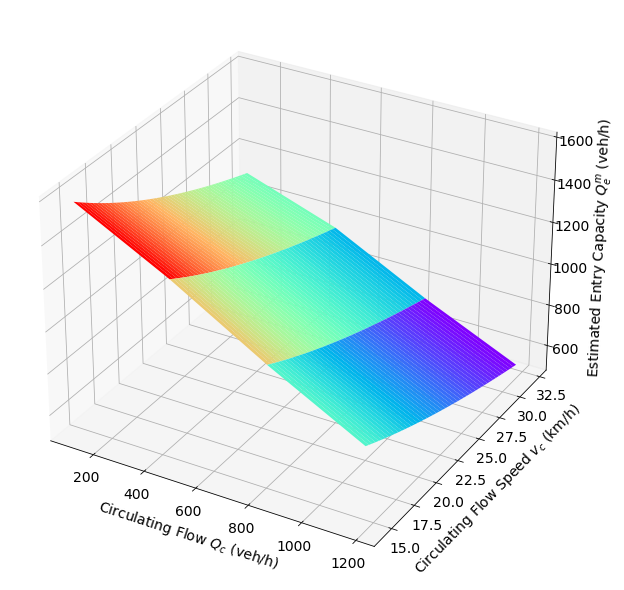

In [83]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from scipy import misc
import math


def circulating_flow(x_q_c,t_rps,vc,alpha):
    return x_q_c * (math.exp(-x_q_c*(2*t_rps+vc/alpha))+math.exp(-x_q_c*(3*t_rps+(6/5)*vc/alpha))+math.exp(-x_q_c*(4*t_rps+(8/5)*vc/alpha))+\
                    math.exp(-x_q_c*(5*t_rps+(11/5)*vc/alpha))+math.exp(-x_q_c*(6*t_rps+(15/5)*vc/alpha))+\
                    math.exp(-x_q_c*(7*t_rps+(20/5)*vc/alpha))/(1-math.exp(-x_q_c*(t_rps+vc/alpha))))



alpha=14.8*0.3048   
t_rps=1.33


qc_all = np.arange(0.03, 0.4, 0.1)
vc_all = np.arange(4, 9, 0.1)
qc_all, vc_all = np.meshgrid(qc_all, vc_all)
q_e = np.zeros(qc_all.shape)


[rows, cols] = qc_all.shape

for i in range(rows):
    for j in range(cols):
        qc = qc_all[i,j]
        vc = vc_all[i,j]
        q_e[i,j]= circulating_flow(qc,t_rps,vc,alpha)





fig = plt.figure(figsize=(11,8))
ax = Axes3D(fig)

labels = ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()

[label.set_fontsize(14) for label in labels]



ax.plot_surface(qc_all*3600, vc_all*3.6, q_e*3600, rstride=1, cstride=1, cmap='rainbow')
# q_e.max()*3600 #1581.476836756374
# q_e.min()*3600 # 525.5777137258116
ax.set_zlim(500, 1600)
plt.xlabel('Circulating Flow $Q_c$ (veh/h)',size = 14, labelpad=10)
plt.ylabel('Circulating Flow Speed $v_c$ (km/h)',size = 14, labelpad=10)
ax.set_zlabel('Estimated Entry Capacity $Q_e^m$ (veh/h)',fontsize=14,labelpad=10)
#plt.zlabel('Estimated Entry Capacity $Q_e$',size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.savefig('3D.jpg')
plt.show()

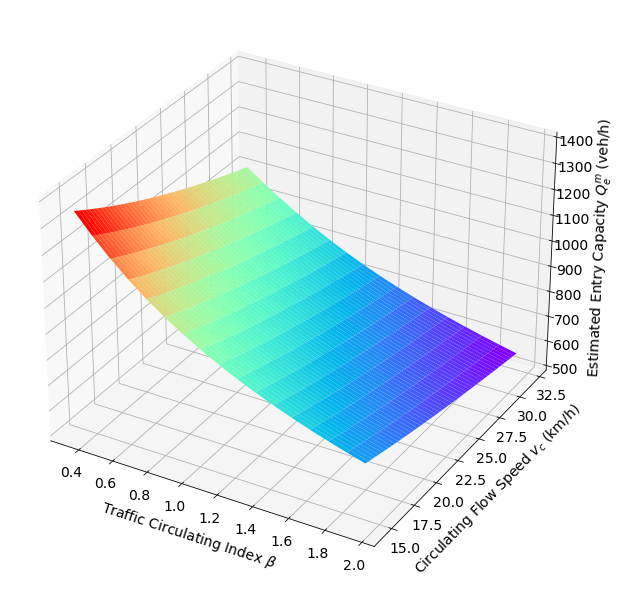

In [89]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from scipy import misc
import math
def f_qc(x):
    return beta1*(math.exp(-x*(2*t_rps+vc/alpha))+math.exp(-x*(3*t_rps+(6/5)*vc/alpha))+math.exp(-x*(4*t_rps+(8/5)*vc/alpha))+\
                 math.exp(-x*(5*t_rps+(11/5)*vc/alpha))+math.exp(-x*(6*t_rps+(15/5)*vc/alpha))+\
                 math.exp(-x*(7*t_rps+(20/5)*vc/alpha))/(1-math.exp(-x*(t_rps+vc/alpha))))-1 

def NewtonsMethod(f, x, tolerance=0.000001):
    while True:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
    return x

alpha=14.8*0.3048   
t_rps=1.33
x=0.5

beta1_all = np.arange(0.35, 2, 0.1)
vc_all = np.arange(4, 9, 0.1)
beta1_all, vc_all = np.meshgrid(beta1_all, vc_all)
q_c = np.zeros(beta1_all.shape)
q_e = np.zeros(beta1_all.shape)


[rows, cols] = beta1_all.shape

for i in range(rows):
    for j in range(cols):
        beta1 = beta1_all[i,j]
        vc = vc_all[i,j]
        x=0.5
        q_c[i,j]=NewtonsMethod(f_qc, x)
        q_e[i,j]= q_c[i,j]/beta1




fig = plt.figure(figsize=(11,8))
ax = Axes3D(fig)

labels = ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()

[label.set_fontsize(14) for label in labels]



ax.plot_surface(beta1_all, vc_all*3.6, q_e*3600, rstride=1, cstride=1, cmap='rainbow')
# q_e.max()*3600 #567.3725538222404
# q_e.min()*3600 # 1350.9808679160465
ax.set_zlim(500, 1400)
plt.xlabel('Traffic Circulating Index $\\beta$',size = 14, labelpad=10)
plt.ylabel('Circulating Flow Speed $v_c$ (km/h)',size = 14, labelpad=10)
ax.set_zlabel('Estimated Entry Capacity $Q_e^m$ (veh/h)',fontsize=14,labelpad=10)
#plt.zlabel('Estimated Entry Capacity $Q_e$',size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)

plt.savefig('3D_beta_vc.jpg')
plt.show()